<img src="https://sites.google.com/a/pythonpredictions.com/wiki/_/rsrc/1484769080787/home/pythongrey%20large.png?height=58&width=200" height="150" width="150" align="right">

# COBRA v1.0.0
----------------------------------------------------------------------------------------------------------
**Autors**: Jan Benisek, Matthias Roels, Geert Verstraeten

**Date**: 25/03/2020

**Purpose**: Example usage of COBRA 1.0.0

**Requirements**: Python 3.6, COBRA library (installation, see README)

----------------------------------------------------------------------------------------------------------
  
## List of content
  * Data transformation
  * Univariate selection
  * Model building

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# third party imports  
import pandas as pd 

# Custom imports
from cobra.preprocessing import PreProcessor
from cobra.model_building import univariate_selection
from cobra.model_building import ForwardFeatureSelection

from cobra.evaluation import generate_pig_tables
from cobra.evaluation import plot_performance_curves
from cobra.evaluation import plot_variable_importance
from cobra.evaluation import plot_univariate_predictor_quality
from cobra.evaluation import plot_correlation_matrix
from cobra.evaluation import Evaluator

## <font color='blue'>Data Loading</font>
The first step is to load a dataset into a pandas DataFrame. This step is not part of COBRA as we want to keep the flexibility the load from different data sources

In [3]:
path = """

basetable = pd.read_csv(path)

basetable.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,scat_1,scat_2,scat_3,scat_4,scat_5,sflag_1,sflag_2,sflag_3,sflag_4,sflag_5
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,...,A,C,C,A,A,0,1,0,0,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,...,B,B,A,B,A,1,0,0,0,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,...,A,C,A,A,F,0,1,0,1,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,...,B,B,C,A,B,0,0,1,0,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,...,B,B,C,C,A,1,0,0,0,1


In [4]:
basetable.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'TARGET', 'ID', 'scont_1', 'scont_2', 'scont_3', 'scont_4', 'scont_5',
       'scont_6', 'scont_7', 'scont_8', 'scont_9', 'scont_10', 'scat_1',
       'scat_2', 'scat_3', 'scat_4', 'scat_5', 'sflag_1', 'sflag_2', 'sflag_3',
       'sflag_4', 'sflag_5'],
      dtype='object')

## <font color='blue'>Data preparation</font>

In [5]:
# Prepare data
path = ""
preprocessor = PreProcessor.from_params(serialization_path=path)

basetable = preprocessor.train_selection_validation_split(basetable, target_column_name="TARGET",
                                                          train_prop=0.6, selection_prop=0.2,
                                                          validation_prop=0.2)
basetable.split.value_counts()

train         29305
validation     9769
selection      9768
Name: split, dtype: int64

In [6]:
# create lists containing the continuous and discrete variables 
continuous_vars = ["age", "capital-gain", "capital-loss"] + [f"scont_{i}" for i in range(1, 11)]
discrete_vars = (["workclass", "fnlwgt", "education", "marital-status",
                  "occupation", "relationship", "race", "sex",
                  "hours-per-week", "native-country"] 
                 + [f"scat_{i}" for i in range(1, 6)] 
                 + [f"sflag_{i}" for i in range(1, 6)])

In [7]:
preprocessor.fit(basetable[basetable["split"]=="train"],
                 continuous_vars=continuous_vars, discrete_vars=discrete_vars,
                 target_column_name="TARGET")

Only 1 bin was found for predictor 'capital-gain' so it will be ignored in computation
Only 1 bin was found for predictor 'capital-loss' so it will be ignored in computation
The number of actual bins for predictor 'scont_1' is 4 which is smaller than the requested number of bins 10
The number of actual bins for predictor 'scont_2' is 9 which is smaller than the requested number of bins 10
/home/matthias/.local/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/matthias/.local/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [8]:
basetable = (preprocessor
             .transform(basetable,
                        continuous_vars=continuous_vars, 
                        discrete_vars=discrete_vars))

Unknown column 'capital-gain_bin' will be skipped
Unknown column 'capital-loss_bin' will be skipped


In [9]:
basetable.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,scont_1_enc,scont_2_enc,scont_3_enc,scont_4_enc,scont_5_enc,scont_6_enc,scont_7_enc,scont_8_enc,scont_9_enc,scont_10_enc
0,56,Self-emp-not-inc,206149,7th-8th,4,Never-married,Other-service,Unmarried,Black,Female,...,0.240395,0.248292,0.234307,0.240191,0.248383,0.236050,0.245621,0.228513,0.230132,0.229873
1,38,Self-emp-not-inc,342635,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,...,0.230626,0.223856,0.235635,0.233058,0.237876,0.247832,0.242909,0.237694,0.244211,0.227472
2,60,Self-emp-not-inc,197060,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,...,0.243971,0.267262,0.234307,0.246637,0.248383,0.225694,0.233650,0.232350,0.244211,0.229873
3,21,Private,113106,HS-grad,9,Never-married,Sales,Other-relative,White,Female,...,0.240395,0.244848,0.234307,0.233058,0.237245,0.244987,0.245621,0.245230,0.244211,0.229873
4,27,Private,169117,HS-grad,9,Married-civ-spouse,Adm-clerical,Wife,Black,Female,...,0.230626,0.244848,0.229594,0.246637,0.232236,0.233454,0.242909,0.241368,0.240012,0.227472


## <font color='blue'>Univariate selection</font>


In [10]:
preprocessed_predictors = [col for col in basetable.columns if col.endswith("_enc")]
print(preprocessed_predictors)

['workclass_enc', 'fnlwgt_enc', 'education_enc', 'marital-status_enc', 'occupation_enc', 'relationship_enc', 'race_enc', 'sex_enc', 'hours-per-week_enc', 'native-country_enc', 'scat_1_enc', 'scat_2_enc', 'scat_3_enc', 'scat_4_enc', 'scat_5_enc', 'sflag_1_enc', 'sflag_2_enc', 'sflag_3_enc', 'sflag_4_enc', 'sflag_5_enc', 'age_enc', 'scont_1_enc', 'scont_2_enc', 'scont_3_enc', 'scont_4_enc', 'scont_5_enc', 'scont_6_enc', 'scont_7_enc', 'scont_8_enc', 'scont_9_enc', 'scont_10_enc']


In [11]:
df_auc = univariate_selection.compute_univariate_preselection(
    target_enc_train_data=basetable[basetable["split"] == "train"],
    target_enc_selection_data=basetable[basetable["split"] == "selection"],
    predictors=preprocessed_predictors,
    target_column="TARGET")

Below is first 10 rows of the output of univariate selection. You can see AUC on train and test and column preselection, which shows which variables met the first selection criteria (AUC >= 0.53 and not overtrained).

In [12]:
df_auc.head(n=10)

,predictor,AUC train,AUC selection,preselection
0,relationship,0.777379,0.779450,True
1,marital-status,0.767728,0.771644,True
2,occupation,0.727460,0.734469,True
3,age,0.707488,0.716277,True
4,education,0.717664,0.714776,True
5,hours-per-week,0.667920,0.664445,True
6,sex,0.617710,0.622441,True
7,workclass,0.584366,0.584248,True
8,race,0.533289,0.535948,True
9,native-country,0.514099,0.513408,True


Second output is a correlation matrix.

In [13]:
df_corr = (univariate_selection
           .compute_correlations(basetable[basetable["split"] == "train"],
                                 predictors=preprocessed_predictors))

Clearly, for meaningful inspection, we need to visualize the data. Therefore, below are plots for **Predictor quality** and **Correlation Matrix**.

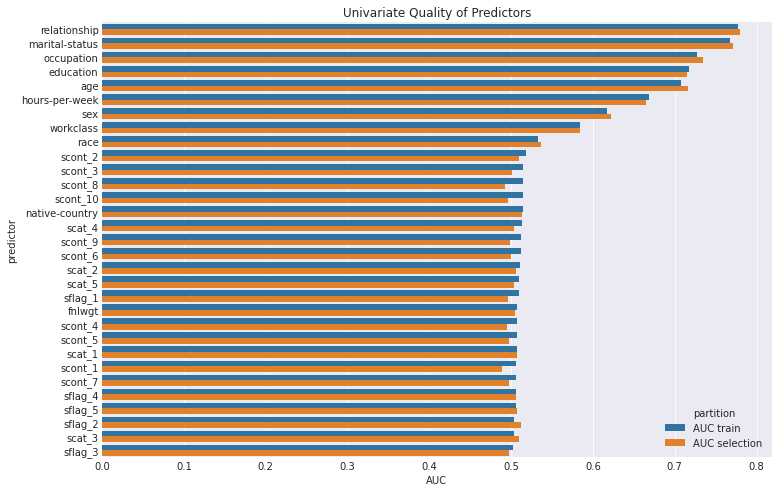

In [14]:
plot_univariate_predictor_quality(df_auc)

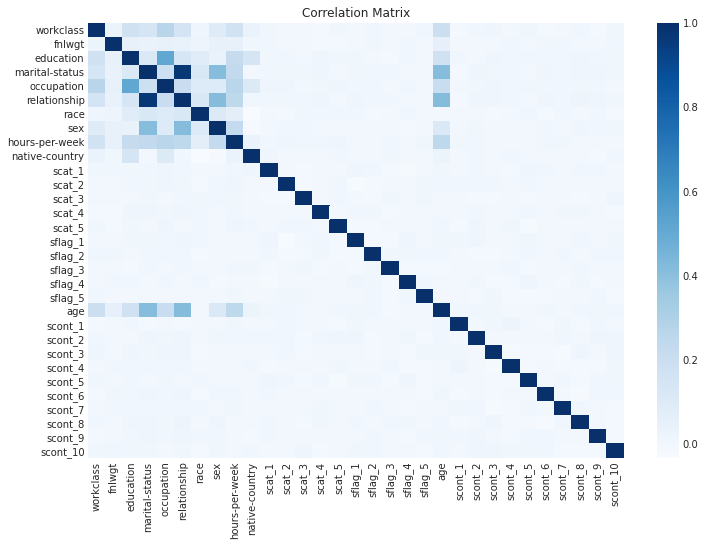

In [15]:
plot_correlation_matrix(df_corr)

### Create pig tables 

In [16]:
columns = [col for col in basetable.columns if col.endswith("_bin") or col.endswith("_processed")]

In [17]:
pigs = generate_pig_tables(basetable[basetable["split"] == "train"],
                           id_column_name="ID", target_column_name="TARGET",
                           preprocessed_predictors= columns)

In [18]:
# As you can see below, the pigs DataFrame is idealy suited to export to csv and load into Jan's Excel template!
pigs.tail(n=10)

,variable,label,pop_size,avg_incidence,incidence
1,sflag_4_processed,1,0.499198,0.239277,0.243216
0,sflag_5_processed,0,0.503395,0.239277,0.235426
1,sflag_5_processed,1,0.496605,0.239277,0.243180
0,workclass_processed,?,0.057430,0.239277,0.093880
1,workclass_processed,Federal-gov,0.029790,0.239277,0.388316
2,workclass_processed,Local-gov,0.065791,0.239277,0.303423
3,workclass_processed,Other,0.040915,0.239277,0.262719
4,workclass_processed,Private,0.690599,0.239277,0.218006
5,workclass_processed,Self-emp-inc,0.034977,0.239277,0.541463
6,workclass_processed,Self-emp-not-inc,0.080498,0.239277,0.274693


In [19]:
preselected_predictors = univariate_selection.get_preselected_predictors(df_auc)

## <font color='blue'>Model building</font>
The next step is to find the best model. COBRA allows you to build a model and specify which variables will be forced or excluded.

In [20]:
forward_selection = ForwardFeatureSelection(pos_only=True)

forward_selection.fit(basetable[basetable["split"] == "train"], 
                      "TARGET", 
                      preselected_predictors,
                      forced_predictors=["age_enc"])

In [21]:
performances = forward_selection.compute_model_performances(basetable, "TARGET")

In [22]:
performances.head(n=10)

,predictors,last_added_predictor,train_performance,selection_performance,validation_performance
0,[age_enc],age_enc,0.707488,0.716277,0.703346
1,"[age_enc, relationship_enc]",relationship_enc,0.817672,0.823040,0.823285
2,"[age_enc, relationship_enc, education_enc]",education_enc,0.870507,0.872161,0.871720
3,"[age_enc, relationship_enc, education_enc, occ...",occupation_enc,0.878316,0.882509,0.880340
4,"[age_enc, relationship_enc, occupation_enc, ed...",hours-per-week_enc,0.882722,0.885464,0.885040
5,"[occupation_enc, age_enc, hours-per-week_enc, ...",fnlwgt_enc,0.883650,0.885744,0.885099
6,"[fnlwgt_enc, occupation_enc, age_enc, hours-pe...",native-country_enc,0.884048,0.886110,0.885772
7,"[fnlwgt_enc, occupation_enc, native-country_en...",marital-status_enc,0.884377,0.886766,0.886017
8,"[fnlwgt_enc, occupation_enc, native-country_en...",scont_2_enc,0.884610,0.886622,0.885594
9,"[fnlwgt_enc, occupation_enc, native-country_en...",workclass_enc,0.884795,0.886878,0.885854


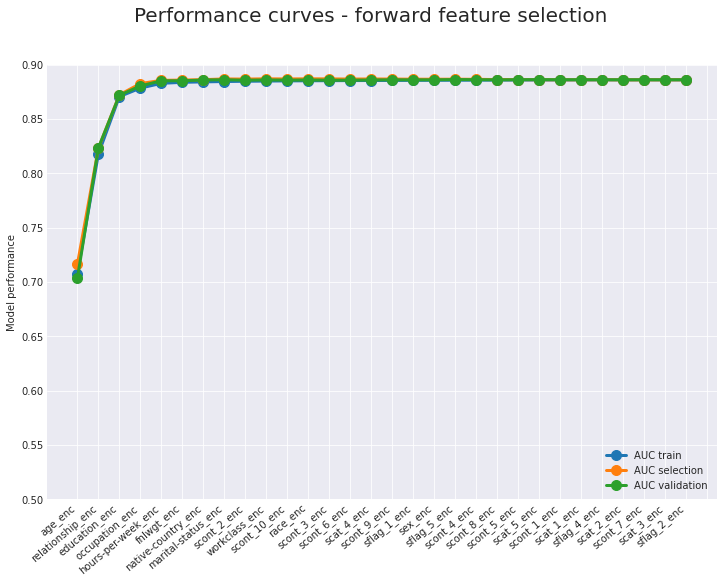

In [23]:
plot_performance_curves(performances)

## <font color='blue'>Model selection and evaluation</font>

In [24]:
model = forward_selection.get_model_from_step(3)  # Python starts to count from 0!
print(model.predictors)

['age_enc', 'relationship_enc', 'education_enc', 'occupation_enc']


In [25]:
importance_by_variable = model.compute_variable_importance(basetable)
importance_by_variable

,predictor,importance
0,relationship,0.747456
1,education,0.609713
2,occupation,0.572291
3,age,0.524466


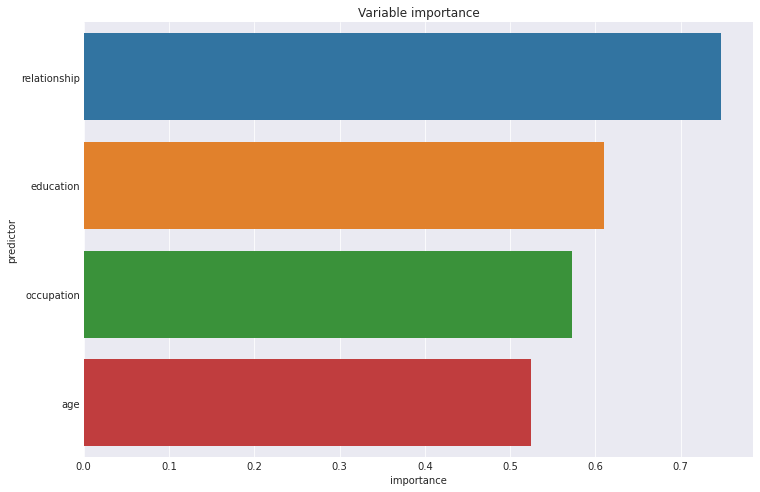

In [26]:
plot_variable_importance(importance_by_variable)

In [27]:
y_true = basetable[basetable["split"] == "selection"]["TARGET"].values
y_pred = model.score_model(basetable[basetable["split"] == "selection"])

In [28]:
evaluator = Evaluator()
evaluator.fit(y_true, y_pred)

In [29]:
# Get various scalar metrics such as accuracy, AUC, precision, recall, ...
evaluator.scalar_metrics

accuracy        0.798628
AUC             0.882509
precision       0.555125
recall          0.797176
F1              0.654488
lift at 0.05    3.420000
dtype: float64

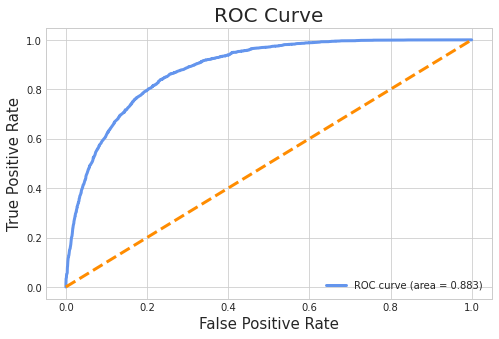

In [36]:
evaluator.plot_roc_curve(dim=(8, 5))

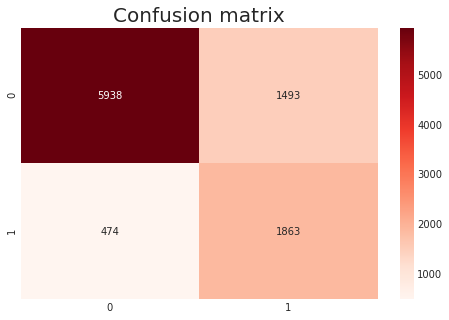

In [31]:
evaluator.plot_confusion_matrix(dim=(8, 5))

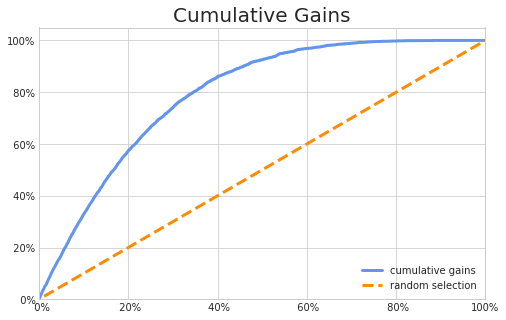

In [35]:
evaluator.plot_cumulative_gains(dim=(8, 5))

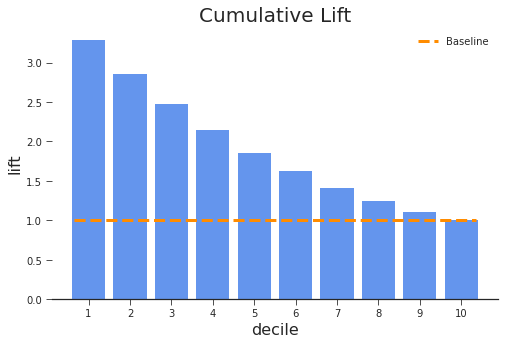

In [33]:
evaluator.plot_lift_curve(dim=(8, 5))

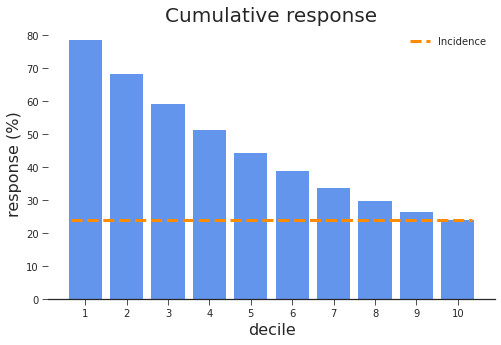

In [34]:
evaluator.plot_cumulative_response_curve(dim=(8, 5))